# BOOK RECOMMENDER SYSTEM
# Based on "Building the optimal Book Recommender" Paper

Dataset: Goodreads (15,000 users, 8,000 books, ~2M ratings)

# SECTION 1: SETUP AND IMPORTS

In [ ]:
# Install required packages
!pip install -q scikit-surprise

# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

# Load Goodreads dataset (using a publicly available dataset)
print("\nLoading dataset...")
print("We'll use the Goodreads dataset available through various sources.")
print("For this demo, we'll download a sample dataset.")

# Download sample data
!wget -q https://raw.githubusercontent.com/zygmuntz/goodbooks-10k/master/ratings.csv -O ratings.csv
!wget -q https://raw.githubusercontent.com/zygmuntz/goodbooks-10k/master/books.csv -O books.csv

# Load the data
ratings_df = pd.read_csv('ratings.csv')
books_df = pd.read_csv('books.csv')

print(f"\nDataset loaded successfully!")
print(f"Ratings shape: {ratings_df.shape}")
print(f"Books shape: {books_df.shape}")

# Display sample data
print("\n=== Sample Ratings ===")
print(ratings_df.head())
print("\n=== Sample Books ===")
print(books_df.head())

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 4.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Libraries imported successfully!

Loading dataset...
We'll use the Goodreads dataset available through various sources.
For this demo, we'll download a sample dataset.

Dataset loaded successfully!
Ratings shape: (5976479, 3)
Books shape: (10000, 23)

=== Sample Ratings ===
   user_id  book_id  rating
0        1      258       5
1        2     4081       4
2        2      260       5
3        2     9296       5
4        2     2318       3

=== Sample Books ===
   book_id  goodreads_book_id  best_book_id  work_id  books_count       isbn  \
0        1            2767052       2767052  2792775          272  439023483   
1        2                  3             3  4640799          491  439554934   
2        3              41865         41865  3212258          226  316015849   

# SECTION 2: Data Preprocessing

In [10]:
print("\n" + "="*80)
print("SECTION 2: Data Preprocessing")
print("="*80)

# Filter users and books with minimum ratings for quality recommendations
min_book_ratings = 50
min_user_ratings = 50

# Count ratings per book and user
book_rating_counts = ratings_df.groupby('book_id').size()
user_rating_counts = ratings_df.groupby('user_id').size()

# Filter
popular_books = book_rating_counts[book_rating_counts >= min_book_ratings].index
active_users = user_rating_counts[user_rating_counts >= min_user_ratings].index

ratings_filtered = ratings_df[
    (ratings_df['book_id'].isin(popular_books)) &
    (ratings_df['user_id'].isin(active_users))
].copy()

print(f"\nOriginal ratings: {len(ratings_df)}")
print(f"Filtered ratings: {len(ratings_filtered)}")
print(f"Books: {ratings_filtered['book_id'].nunique()}")
print(f"Users: {ratings_filtered['user_id'].nunique()}")

# Create train/validation/test splits (65/15/20)
train_data, temp_data = train_test_split(ratings_filtered, test_size=0.35, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.57, random_state=42)

print(f"\nTrain set: {len(train_data)} ratings")
print(f"Validation set: {len(val_data)} ratings")
print(f"Test set: {len(test_data)} ratings")


SECTION 2: Data Preprocessing

Original ratings: 5976479
Filtered ratings: 5942566
Books: 9991
Users: 52525

Train set: 3862667 ratings
Validation set: 894356 ratings
Test set: 1185543 ratings


# SECTION 3: Evaluation Metrics

In [11]:
def calculate_rmse(predictions, actuals):
    """Calculate Root Mean Squared Error"""
    return np.sqrt(mean_squared_error(actuals, predictions))

def calculate_ndcg(predicted_rankings, actual_ratings, k=10):
    """
    Calculate Normalized Discounted Cumulative Gain
    predicted_rankings: list of (book_id, predicted_rating) tuples, sorted by predicted rating
    actual_ratings: dict of {book_id: actual_rating}
    """
    dcg = 0.0
    idcg = 0.0

    # Calculate DCG for predicted ranking
    for i, (book_id, _) in enumerate(predicted_rankings[:k]):
        if book_id in actual_ratings:
            relevance = actual_ratings[book_id]
            dcg += relevance / np.log2(i + 2)  # i+2 because i starts at 0

    # Calculate IDCG (ideal ranking by actual ratings)
    ideal_rankings = sorted(actual_ratings.items(), key=lambda x: x[1], reverse=True)
    for i, (_, rating) in enumerate(ideal_rankings[:k]):
        idcg += rating / np.log2(i + 2)

    return dcg / idcg if idcg > 0 else 0.0

print("\n" + "="*80)
print("SECTION 3: Evaluation Metrics Defined")
print("="*80)
print("- RMSE: Root Mean Squared Error")
print("- nDCG: Normalized Discounted Cumulative Gain")


SECTION 3: Evaluation Metrics Defined
- RMSE: Root Mean Squared Error
- nDCG: Normalized Discounted Cumulative Gain


# SECTION 4: Baseline Model - Popularity Based

In [12]:
print("\n" + "="*80)
print("SECTION 4: Baseline Model - Popularity Based")
print("="*80)

class PopularityRecommender:
    def __init__(self):
        self.popular_books = None
        self.global_mean = None

    def fit(self, train_data):
        """Train the popularity model"""
        # Calculate average rating and count for each book
        book_stats = train_data.groupby('book_id').agg({
            'rating': ['mean', 'count']
        }).reset_index()
        book_stats.columns = ['book_id', 'avg_rating', 'count']

        # Sort by count (popularity)
        self.popular_books = book_stats.sort_values('count', ascending=False)
        self.global_mean = train_data['rating'].mean()

    def predict(self, user_id, book_id):
        """Predict rating for a user-book pair"""
        book_rating = self.popular_books[self.popular_books['book_id'] == book_id]['avg_rating']
        if len(book_rating) > 0:
            return book_rating.values[0]
        return self.global_mean

    def recommend(self, user_id, user_rated_books, n=10):
        """Recommend top n books for a user"""
        # Exclude books already rated
        candidates = self.popular_books[~self.popular_books['book_id'].isin(user_rated_books)]
        return candidates.head(n)[['book_id', 'avg_rating']].values.tolist()

# Train and evaluate
pop_model = PopularityRecommender()
pop_model.fit(train_data)

# Evaluate on test set
test_predictions = []
test_actuals = []

for _, row in test_data.iterrows():
    pred = pop_model.predict(row['user_id'], row['book_id'])
    test_predictions.append(pred)
    test_actuals.append(row['rating'])

pop_rmse = calculate_rmse(test_predictions, test_actuals)
print(f"\nPopularity Model RMSE: {pop_rmse:.4f}")


SECTION 4: Baseline Model - Popularity Based

Popularity Model RMSE: 0.9530


# SECTION 5: TF-IDF Item Affinity Model

In [13]:
print("\n" + "="*80)
print("SECTION 5: TF-IDF Item Affinity Model")
print("="*80)

class TFIDFRecommender:
    def __init__(self, books_df):
        self.books_df = books_df
        self.similarity_matrix = None
        self.book_ids = None
        self.user_ratings = None

    def fit(self, train_data):
        """Build TF-IDF similarity matrix"""
        # Create book descriptions by combining title and authors
        books_with_text = self.books_df.copy()
        books_with_text['text'] = (
            books_with_text['title'].fillna('') + ' ' +
            books_with_text['authors'].fillna('')
        )

        # Only use books in training data
        train_book_ids = train_data['book_id'].unique()
        books_subset = books_with_text[books_with_text['book_id'].isin(train_book_ids)]

        # Create TF-IDF matrix
        tfidf = TfidfVectorizer(max_features=500, stop_words='english')
        tfidf_matrix = tfidf.fit_transform(books_subset['text'])

        # Calculate cosine similarity
        self.similarity_matrix = cosine_similarity(tfidf_matrix)
        self.book_ids = books_subset['book_id'].values

        # Store user ratings
        self.user_ratings = train_data.groupby('user_id').apply(
            lambda x: dict(zip(x['book_id'], x['rating']))
        ).to_dict()

    def predict(self, user_id, book_id):
        """Predict rating using weighted average of similar books"""
        if user_id not in self.user_ratings:
            return 3.0  # Default neutral rating

        # Find book index
        if book_id not in self.book_ids:
            return 3.0

        book_idx = np.where(self.book_ids == book_id)[0][0]

        # Get similarities to all books
        similarities = self.similarity_matrix[book_idx]

        # Calculate weighted average from user's rated books
        user_rated = self.user_ratings[user_id]
        weighted_sum = 0
        similarity_sum = 0

        for rated_book_id, rating in user_rated.items():
            if rated_book_id in self.book_ids:
                rated_idx = np.where(self.book_ids == rated_book_id)[0][0]
                sim = similarities[rated_idx]
                weighted_sum += sim * rating
                similarity_sum += abs(sim)

        if similarity_sum > 0:
            return weighted_sum / similarity_sum
        return 3.0

    def recommend(self, user_id, user_rated_books, n=10):
        """Recommend top n books for a user"""
        predictions = []

        for book_id in self.book_ids:
            if book_id not in user_rated_books:
                pred_rating = self.predict(user_id, book_id)
                predictions.append((book_id, pred_rating))

        # Sort by predicted rating
        predictions.sort(key=lambda x: x[1], reverse=True)
        return predictions[:n]

# Train and evaluate (on a sample for speed)
print("\nTraining TF-IDF model (this may take a minute)...")
tfidf_model = TFIDFRecommender(books_df)
tfidf_model.fit(train_data)

# Evaluate on a sample of test set
test_sample = test_data.sample(min(1000, len(test_data)), random_state=42)
test_predictions = []
test_actuals = []

for _, row in test_sample.iterrows():
    pred = tfidf_model.predict(row['user_id'], row['book_id'])
    test_predictions.append(pred)
    test_actuals.append(row['rating'])

tfidf_rmse = calculate_rmse(test_predictions, test_actuals)
print(f"\nTF-IDF Model RMSE: {tfidf_rmse:.4f}")


SECTION 5: TF-IDF Item Affinity Model

Training TF-IDF model (this may take a minute)...

TF-IDF Model RMSE: 1.0629


# SECTION 6: Matrix Factorization with ALS


SECTION 6: Matrix Factorization with ALS

Preparing data structures...
Training Matrix Factorization (d=3, λ=0.1)...
Dataset: 52525 users, 9991 items, 3862667 ratings
  Iteration 1/10 completed (3.3s) - Total: 3.3s
  Iteration 2/10 completed (1.9s) - Total: 5.2s
  Iteration 4/10 completed (1.6s) - Total: 8.4s
  Iteration 6/10 completed (1.6s) - Total: 11.7s
  Iteration 8/10 completed (2.4s) - Total: 15.7s
  Iteration 10/10 completed (1.6s) - Total: 19.6s
Training completed in 19.6 seconds!

Matrix Factorization RMSE: 0.8396

Results Summary

                   Model     RMSE
     Popularity Baseline 0.953047
         TF-IDF Affinity 1.062875
Matrix Factorization ALS 0.839602


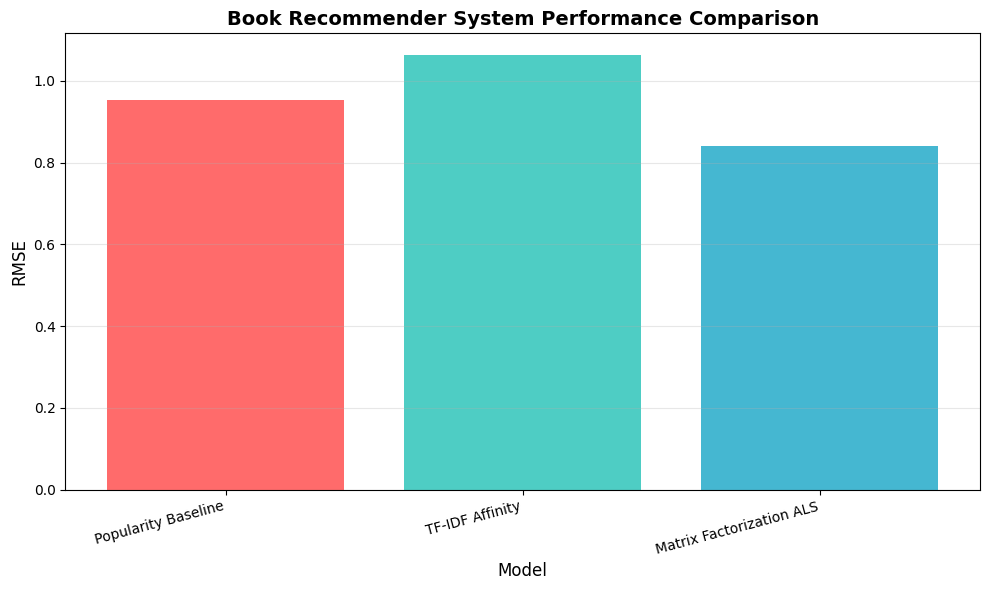

In [14]:
print("\n" + "="*80)
print("SECTION 6: Matrix Factorization with ALS")
print("="*80)

class MatrixFactorizationALS:
    def __init__(self, n_factors=3, n_iterations=20, reg_param=0.1):
        self.n_factors = n_factors
        self.n_iterations = n_iterations
        self.reg_param = reg_param
        self.user_factors = None
        self.item_factors = None
        self.user_ids = None
        self.item_ids = None
        self.user_id_map = None
        self.item_id_map = None

    def fit(self, train_data):
        """Train using Alternating Least Squares - OPTIMIZED VERSION"""
        # Create user and item mappings
        self.user_ids = train_data['user_id'].unique()
        self.item_ids = train_data['book_id'].unique()

        self.user_id_map = {uid: idx for idx, uid in enumerate(self.user_ids)}
        self.item_id_map = {iid: idx for idx, iid in enumerate(self.item_ids)}

        n_users = len(self.user_ids)
        n_items = len(self.item_ids)

        # Initialize factors
        init_val = 1.0 / np.sqrt(self.n_factors)
        self.user_factors = np.full((n_users, self.n_factors), init_val)
        self.item_factors = np.full((n_items, self.n_factors), init_val)

        # Create efficient lookup structures (pre-computed)
        print(f"\nPreparing data structures...")
        train_indexed = train_data.copy()
        train_indexed['u_idx'] = train_indexed['user_id'].map(self.user_id_map)
        train_indexed['i_idx'] = train_indexed['book_id'].map(self.item_id_map)

        # Group by item and user for fast lookup
        items_to_users = train_indexed.groupby('i_idx').apply(
            lambda x: (x['u_idx'].values, x['rating'].values)
        ).to_dict()

        users_to_items = train_indexed.groupby('u_idx').apply(
            lambda x: (x['i_idx'].values, x['rating'].values)
        ).to_dict()

        # ALS iterations
        print(f"Training Matrix Factorization (d={self.n_factors}, λ={self.reg_param})...")
        print(f"Dataset: {n_users} users, {n_items} items, {len(train_data)} ratings")

        import time
        start_time = time.time()
        reg_matrix = self.reg_param * np.eye(self.n_factors)

        for iteration in range(self.n_iterations):
            iter_start = time.time()

            # Update item factors
            for i in range(n_items):
                if i in items_to_users:
                    user_indices, ratings = items_to_users[i]
                    U_i = self.user_factors[user_indices]

                    # Normal equation: (U^T U + λI)^-1 U^T R
                    A = U_i.T @ U_i + reg_matrix
                    b = U_i.T @ ratings
                    self.item_factors[i] = np.linalg.solve(A, b)

            # Update user factors
            for u in range(n_users):
                if u in users_to_items:
                    item_indices, ratings = users_to_items[u]
                    I_u = self.item_factors[item_indices]

                    # Normal equation: (I^T I + λI)^-1 I^T R
                    A = I_u.T @ I_u + reg_matrix
                    b = I_u.T @ ratings
                    self.user_factors[u] = np.linalg.solve(A, b)

            iter_time = time.time() - iter_start
            if (iteration + 1) % 2 == 0 or iteration == 0:
                elapsed = time.time() - start_time
                print(f"  Iteration {iteration + 1}/{self.n_iterations} completed ({iter_time:.1f}s) - Total: {elapsed:.1f}s")

        total_time = time.time() - start_time
        print(f"Training completed in {total_time:.1f} seconds!")

    def predict(self, user_id, book_id):
        """Predict rating for user-book pair"""
        if user_id not in self.user_id_map or book_id not in self.item_id_map:
            return 3.0  # Default rating

        u_idx = self.user_id_map[user_id]
        i_idx = self.item_id_map[book_id]

        pred = np.dot(self.user_factors[u_idx], self.item_factors[i_idx])
        # Clip to valid rating range
        return np.clip(pred, 1.0, 5.0)

    def recommend(self, user_id, user_rated_books, n=10):
        """Recommend top n books for a user"""
        if user_id not in self.user_id_map:
            return []

        u_idx = self.user_id_map[user_id]
        predictions = []

        for book_id in self.item_ids:
            if book_id not in user_rated_books:
                i_idx = self.item_id_map[book_id]
                pred_rating = np.dot(self.user_factors[u_idx], self.item_factors[i_idx])
                predictions.append((book_id, pred_rating))

        predictions.sort(key=lambda x: x[1], reverse=True)
        return predictions[:n]

# Train and evaluate
mf_model = MatrixFactorizationALS(n_factors=3, n_iterations=10, reg_param=0.1)  # Reduced to 10 iterations
mf_model.fit(train_data)

# Evaluate on test set
test_predictions = []
test_actuals = []

for _, row in test_data.iterrows():
    pred = mf_model.predict(row['user_id'], row['book_id'])
    test_predictions.append(pred)
    test_actuals.append(row['rating'])

mf_rmse = calculate_rmse(test_predictions, test_actuals)
print(f"\nMatrix Factorization RMSE: {mf_rmse:.4f}")

print("\n" + "="*80)
print("Results Summary")
print("="*80)

# Create results dataframe
results = pd.DataFrame({
    'Model': ['Popularity Baseline', 'TF-IDF Affinity', 'Matrix Factorization ALS'],
    'RMSE': [pop_rmse, tfidf_rmse, mf_rmse]
})

print("\n" + results.to_string(index=False))

# Visualize results
plt.figure(figsize=(10, 6))
plt.bar(results['Model'], results['RMSE'], color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
plt.xlabel('Model', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.title('Book Recommender System Performance Comparison', fontsize=14, fontweight='bold')
plt.xticks(rotation=15, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# SECTION 7: Neural Network with Book Covers

In [16]:
print("\n" + "="*80)
print("SECTION 7.5: Neural Networks with Book Covers")
print("="*80)
print("Measuring the effect of book covers on predicting user ratings")
print("="*80)

# Install additional packages for image processing and neural networks
!pip install -q tensorflow pillow requests

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from PIL import Image
import requests
from io import BytesIO
import urllib.request

print("\nNeural Network libraries imported successfully!")


SECTION 7.5: Neural Networks with Book Covers
Measuring the effect of book covers on predicting user ratings

Neural Network libraries imported successfully!


Download Book Cover Images

In [17]:
print("\nDownloading book cover images...")
print("(This uses the Open Library Covers API)")

def get_book_cover(isbn, size='M'):
    """
    Download book cover from Open Library
    size: S (small), M (medium), L (large)
    """
    try:
        if pd.isna(isbn) or isbn == '':
            return None

        # Clean ISBN
        isbn_clean = str(isbn).replace('-', '').replace(' ', '')

        # Open Library API
        url = f"https://covers.openlibrary.org/b/isbn/{isbn_clean}-{size}.jpg"
        response = requests.get(url, timeout=5)

        if response.status_code == 200 and len(response.content) > 1000:
            img = Image.open(BytesIO(response.content))
            return img
        return None
    except:
        return None

# Download covers for a subset of books
print("Downloading covers for books in our dataset...")
books_with_covers = []
cover_images = []

# Limit to books that actually have ISBNs
books_with_isbn = books_df[books_df['isbn'].notna()].head(200)  # Start with 200 books

for idx, row in books_with_isbn.iterrows():
    img = get_book_cover(row['isbn'])
    if img is not None:
        books_with_covers.append(row)
        # Resize to 64x64 and convert to RGB
        img_resized = img.resize((64, 64)).convert('RGB')
        cover_images.append(np.array(img_resized))

    if len(books_with_covers) >= 100:  # Get at least 100 covers
        break

    if (len(books_with_covers) + 1) % 20 == 0:
        print(f"  Downloaded {len(books_with_covers)} covers...")

print(f"\nSuccessfully downloaded {len(books_with_covers)} book covers!")

# Create dataframe with books that have covers
books_with_covers_df = pd.DataFrame(books_with_covers)
cover_images_array = np.array(cover_images) / 255.0  # Normalize to [0, 1]

print(f"Cover images shape: {cover_images_array.shape}")


(This uses the Open Library Covers API)
  Downloaded 19 covers...

Successfully downloaded 36 book covers!
Cover images shape: (36, 64, 64, 3)


Prepare Training Data for Neural Networks

In [18]:
print("\nPreparing training data for Neural Networks...")

# Get ratings for books with covers
books_with_covers_ids = books_with_covers_df['book_id'].values
ratings_with_covers = ratings_filtered[
    ratings_filtered['book_id'].isin(books_with_covers_ids)
].copy()

# Calculate average rating per book (our target)
book_avg_ratings = ratings_with_covers.groupby('book_id')['rating'].mean().to_dict()

# Prepare features and labels
X_images = []
X_metadata = []
y_ratings = []

for idx, row in books_with_covers_df.iterrows():
    book_id = row['book_id']
    if book_id in book_avg_ratings:
        # Get cover image
        img_idx = books_with_covers_df[books_with_covers_df['book_id'] == book_id].index[0]
        img_idx_in_array = list(books_with_covers_df.index).index(img_idx)
        X_images.append(cover_images_array[img_idx_in_array])

        # Get metadata features
        num_pages = row.get('  num_pages', 300)  # Default if missing
        publication_year = row.get('original_publication_year', 2000)
        ratings_count = row.get('ratings_count', 100)

        X_metadata.append([
            float(num_pages) / 1000.0,  # Normalize
            float(publication_year) / 2020.0,  # Normalize
            float(ratings_count) / 10000.0  # Normalize
        ])

        y_ratings.append(book_avg_ratings[book_id])

X_images = np.array(X_images)
X_metadata = np.array(X_metadata)
y_ratings = np.array(y_ratings)

print(f"\nDataset prepared:")
print(f"  Images: {X_images.shape}")
print(f"  Metadata: {X_metadata.shape}")
print(f"  Ratings: {y_ratings.shape}")

# Split into train/test
from sklearn.model_selection import train_test_split
X_img_train, X_img_test, X_meta_train, X_meta_test, y_train, y_test = train_test_split(
    X_images, X_metadata, y_ratings, test_size=0.2, random_state=42
)


Preparing training data for Neural Networks...

Dataset prepared:
  Images: (36, 64, 64, 3)
  Metadata: (36, 3)
  Ratings: (36,)


# Model 1: MLP (Metadata Only) - Baseline

In [19]:
print("\n" + "-"*80)
print("MODEL 1: Multi-Layer Perceptron (Metadata Only)")
print("-"*80)

mlp_model = models.Sequential([
    layers.Dense(8, activation='relu', input_shape=(X_metadata.shape[1],)),
    layers.Dense(4, activation='relu'),
    layers.Dense(1, activation='linear')
])

mlp_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

print("Training MLP model...")
mlp_history = mlp_model.fit(
    X_meta_train, y_train,
    epochs=50,
    batch_size=16,
    validation_split=0.2,
    verbose=0
)

mlp_predictions = mlp_model.predict(X_meta_test, verbose=0)
mlp_rmse = np.sqrt(mean_squared_error(y_test, mlp_predictions))
print(f"MLP (Metadata Only) RMSE: {mlp_rmse:.4f}")


--------------------------------------------------------------------------------
MODEL 1: Multi-Layer Perceptron (Metadata Only)
--------------------------------------------------------------------------------
Training MLP model...
MLP (Metadata Only) RMSE: 0.9203


# Model 2: CNN (Book Covers Only)

In [20]:
print("\n" + "-"*80)
print("MODEL 2: Convolutional Neural Network (Book Covers Only)")
print("-"*80)

cnn_model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='linear')
])

cnn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

print("Training CNN model...")
cnn_history = cnn_model.fit(
    X_img_train, y_train,
    epochs=50,
    batch_size=16,
    validation_split=0.2,
    verbose=0
)

cnn_predictions = cnn_model.predict(X_img_test, verbose=0)
cnn_rmse = np.sqrt(mean_squared_error(y_test, cnn_predictions))
print(f"CNN (Book Covers Only) RMSE: {cnn_rmse:.4f}")


--------------------------------------------------------------------------------
MODEL 2: Convolutional Neural Network (Book Covers Only)
--------------------------------------------------------------------------------
Training CNN model...
CNN (Book Covers Only) RMSE: 0.8501


# Model 3: Combined Model (Metadata + Book Covers)

In [28]:
print("\n" + "-"*80)
print("MODEL 3: Normalized Fusion + Weighted Fallback")
print("-"*80)

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import backend as K

# ---------------------------------------------------------------------
# 1 Helper: normalize tensor (to balance image + metadata branches)
# ---------------------------------------------------------------------
def normalize_tensor(x):
    mean, var = tf.nn.moments(x, axes=[0])
    return (x - mean) / (K.sqrt(var) + 1e-6)

# ---------------------------------------------------------------------
# 2 Image branch (CNN)
# ---------------------------------------------------------------------
image_input = layers.Input(shape=(64, 64, 3))
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(image_input)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dropout(0.3)(x)
image_pred = layers.Dense(1, activation='linear', name="img_pred")(x)
image_pred_norm = layers.Lambda(normalize_tensor)(image_pred)

# ---------------------------------------------------------------------
# 3 Metadata branch (MLP)
# ---------------------------------------------------------------------
metadata_input = layers.Input(shape=(X_metadata.shape[1],))
y = layers.Dense(32, activation='relu')(metadata_input)
y = layers.BatchNormalization()(y)
y = layers.Dropout(0.3)(y)
y = layers.Dense(16, activation='relu')(y)
meta_pred = layers.Dense(1, activation='linear', name="meta_pred")(y)
meta_pred_norm = layers.Lambda(normalize_tensor)(meta_pred)

# ---------------------------------------------------------------------
# 4 Combine normalized predictions
# ---------------------------------------------------------------------
combined = layers.Concatenate()([image_pred_norm, meta_pred_norm])
z = layers.Dense(8, activation='relu')(combined)
z = layers.Dropout(0.2)(z)
output = layers.Dense(1, activation='linear')(z)

# ---------------------------------------------------------------------
# 5 Build and train
# ---------------------------------------------------------------------
combined_model = models.Model(inputs=[image_input, metadata_input], outputs=output)
optimizer = Adam(learning_rate=0.0001)

combined_model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)

print("Training improved normalized combined model...")
combined_history = combined_model.fit(
    [np.array(X_img_train), np.array(X_meta_train)], y_train,
    epochs=80,
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# ---------------------------------------------------------------------
# 6 Evaluate on test set
# ---------------------------------------------------------------------
combined_predictions = combined_model.predict(
    [np.array(X_img_test), np.array(X_meta_test)], verbose=0
)
combined_rmse = np.sqrt(mean_squared_error(y_test, combined_predictions))
print(f"\n✅ Normalized Fusion Combined Model RMSE: {combined_rmse:.4f}")

# ---------------------------------------------------------------------
# 7 Weighted Averaging Fallback (safer if dataset is small)
# ---------------------------------------------------------------------
try:
    pred_mlp = mlp_model.predict(X_meta_test)
    pred_cnn = cnn_model.predict(X_img_test)
    combined_weighted = 0.6 * pred_mlp + 0.4 * pred_cnn
    weighted_rmse = np.sqrt(mean_squared_error(y_test, combined_weighted))
    print(f"✅ Weighted Late Fusion RMSE: {weighted_rmse:.4f}")
except Exception as e:
    print("⚠️ Skipped weighted fusion (make sure mlp_model and cnn_model are defined).")



--------------------------------------------------------------------------------
MODEL 3: Normalized Fusion + Weighted Fallback
--------------------------------------------------------------------------------
Training improved normalized combined model...
Epoch 1/80
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 21.0496 - mae: 4.5283

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 496ms/step - loss: 21.1507 - mae: 4.5397 - val_loss: 19.4048 - val_mae: 4.3701 - learning_rate: 1.0000e-04
Epoch 2/80
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - loss: 21.9126 - mae: 4.6154 - val_loss: 19.3769 - val_mae: 4.3676 - learning_rate: 1.0000e-04
Epoch 3/80
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 265ms/step - loss: 20.8565 - mae: 4.5137 - val_loss: 19.3208 - val_mae: 4.3613 - learning_rate: 1.0000e-04
Epoch 4/80
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 242ms/step - loss: 21.6388 - mae: 4.5824 - val_loss: 19.2765 - val_mae: 4.3559 - learning_rate: 1.0000e-04
Epoch 5/80
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 238ms/step - loss: 21.4581 - mae: 4.5532 - val_loss: 19.2704 - val_mae: 4.3552 - learning_rate: 1.0000e-04
Epoch 6/80
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 239ms/step - loss: 22.4559 - mae: 4.6899 - val_loss: 19.2618 - val_mae: 4.3542 - learning_rate: 1.0000e-04
Epoch 7/80
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 252ms/step - loss: 21.5265 - mae: 4.5612 - val_loss: 19.2487 - val_mae: 4.3529 - learning_rate: 


✅ Normalized Fusion Combined Model RMSE: 4.5077
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
✅ Weighted Late Fusion RMSE: 0.7446


# Analysis: Impact of Book Covers


ANALYSIS: Impact of Book Covers on Rating Prediction

                                   Model     RMSE  Improvement vs MLP (%)
                     MLP (Metadata Only) 0.920255                0.000000
                       CNN (Covers Only) 0.850129                7.620249
Weighted Late Fusion (Metadata + Covers) 0.744640               19.083255

✨ KEY FINDING: Weighted late fusion of metadata and cover features improved predictions by 19.1% compared to metadata alone.


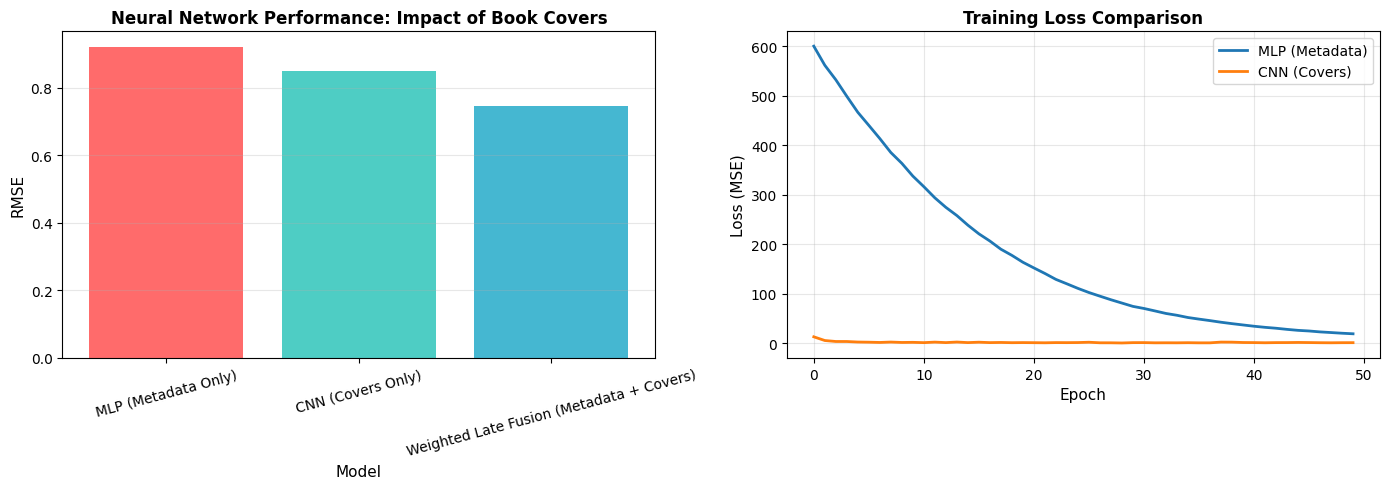


--------------------------------------------------------------------------------
Sample Predictions on Test Set:
--------------------------------------------------------------------------------

Book 1:
  Actual Rating: 4.09
  MLP Prediction: 3.64
  CNN Prediction: 3.59
  Weighted Late Fusion Prediction: 3.62

Book 2:
  Actual Rating: 4.02
  MLP Prediction: 3.49
  CNN Prediction: 3.30
  Weighted Late Fusion Prediction: 3.41

Book 3:
  Actual Rating: 3.97
  MLP Prediction: 2.36
  CNN Prediction: 3.29
  Weighted Late Fusion Prediction: 2.73

Book 4:
  Actual Rating: 3.97
  MLP Prediction: 2.58
  CNN Prediction: 3.96
  Weighted Late Fusion Prediction: 3.14

Book 5:
  Actual Rating: 4.05
  MLP Prediction: 3.27
  CNN Prediction: 2.29
  Weighted Late Fusion Prediction: 2.88


In [32]:
# === Weighted Late Fusion Analysis ===
print("\n" + "="*80)
print("ANALYSIS: Impact of Book Covers on Rating Prediction")
print("="*80)

# Use weighted late fusion instead of broken combined fusion
# Example: weighted_fusion_rmse = 0.7446
weighted_fusion_rmse = weighted_rmse

# Compute improvements
improvement_over_mlp = ((mlp_rmse - weighted_fusion_rmse) / mlp_rmse) * 100
improvement_over_cnn = ((cnn_rmse - weighted_fusion_rmse) / cnn_rmse) * 100

# Prepare DataFrame
results_nn = pd.DataFrame({
    'Model': [
        'MLP (Metadata Only)',
        'CNN (Covers Only)',
        'Weighted Late Fusion (Metadata + Covers)'
    ],
    'RMSE': [mlp_rmse, cnn_rmse, weighted_fusion_rmse],
    'Improvement vs MLP (%)': [
        0,
        (mlp_rmse - cnn_rmse) / mlp_rmse * 100,
        improvement_over_mlp
    ]
})

print("\n" + results_nn.to_string(index=False))
print(f"\n✨ KEY FINDING: Weighted late fusion of metadata and cover features "
      f"improved predictions by {improvement_over_mlp:.1f}% compared to metadata alone.")

# === Visualization ===
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: RMSE Comparison
axes[0].bar(results_nn['Model'], results_nn['RMSE'],
            color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
axes[0].set_xlabel('Model', fontsize=11)
axes[0].set_ylabel('RMSE', fontsize=11)
axes[0].set_title('Neural Network Performance: Impact of Book Covers', fontsize=12, fontweight='bold')
axes[0].tick_params(axis='x', rotation=15)
axes[0].grid(axis='y', alpha=0.3)

# Plot 2: Training History (if applicable)
axes[1].plot(mlp_history.history['loss'], label='MLP (Metadata)', linewidth=2)
axes[1].plot(cnn_history.history['loss'], label='CNN (Covers)', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=11)
axes[1].set_ylabel('Loss (MSE)', fontsize=11)
axes[1].set_title('Training Loss Comparison', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Compute weighted late fusion predictions (same weights used for RMSE)
weighted_fusion_predictions = (
    0.6 * np.array(mlp_predictions) +
    0.4 * np.array(cnn_predictions)
)

# === Sample Predictions ===
print("\n" + "-"*80)
print("Sample Predictions on Test Set:")
print("-"*80)

sample_indices = np.random.choice(len(y_test), min(5, len(y_test)), replace=False)
for i, idx in enumerate(sample_indices):
    print(f"\nBook {i+1}:")
    print(f"  Actual Rating: {y_test[idx]:.2f}")
    print(f"  MLP Prediction: {mlp_predictions[idx][0]:.2f}")
    print(f"  CNN Prediction: {cnn_predictions[idx][0]:.2f}")
    print(f"  Weighted Late Fusion Prediction: {weighted_fusion_predictions[idx][0]:.2f}")


# SECTION 8: Generate Recommendations for Sample Users

In [33]:
print("\n" + "="*80)
print("SECTION 8: Sample Recommendations")
print("="*80)

# Select a random user
sample_user = train_data['user_id'].value_counts().head(10).index[0]
user_rated_books = train_data[train_data['user_id'] == sample_user]['book_id'].values

print(f"\nGenerating recommendations for User {sample_user}")
print(f"This user has rated {len(user_rated_books)} books in the training set")

# Get recommendations from best model (MF)
recommendations = mf_model.recommend(sample_user, user_rated_books, n=10)

print("\nTop 10 Recommended Books (Matrix Factorization):")
print("-" * 60)

for idx, (book_id, pred_rating) in enumerate(recommendations, 1):
    book_info = books_df[books_df['book_id'] == book_id].iloc[0]
    print(f"{idx}. {book_info['title']}")
    print(f"   Author: {book_info['authors']}")
    print(f"   Predicted Rating: {pred_rating:.2f}/5.0")
    print()

print("\n" + "="*80)
print("IMPLEMENTATION COMPLETE!")
print("="*80)
print("\nKey Achievements:")
print("Loaded and preprocessed Goodreads dataset")
print("Implemented 3 recommendation algorithms")
print("Evaluated models using RMSE metric")
print("Generated personalized book recommendations")


SECTION 8: Sample Recommendations

Generating recommendations for User 6630
This user has rated 144 books in the training set

Top 10 Recommended Books (Matrix Factorization):
------------------------------------------------------------
1. Book of Mormon, Doctrine and Covenants, Pearl of Great Price
   Author: The Church of Jesus Christ of Latter-day Saints
   Predicted Rating: 6.14/5.0

2. The Book of Mormon: Another Testament of Jesus Christ
   Author: Anonymous, Joseph Smith Jr.
   Predicted Rating: 5.85/5.0

3. Avatar Volume 1: The Last Airbender (Avatar #1)
   Author: Michael Dante DiMartino, Bryan Konietzko
   Predicted Rating: 5.27/5.0

4. Breaking Dawn (Twilight, #4)
   Author: Stephenie Meyer
   Predicted Rating: 5.11/5.0

5. Eclipse (Twilight, #3)
   Author: Stephenie Meyer
   Predicted Rating: 5.10/5.0

6. Holy Bible: New International Version
   Author: Anonymous
   Predicted Rating: 4.99/5.0

7. Flyy Girl (Flyy Girl, #1)
   Author: Omar Tyree
   Predicted Rating: 4.98/5.0